# Modelisation CamenBERT

## Librairies et fichiers

In [1]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


Import des librairies

In [2]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import CamembertTokenizer, CamembertForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from torch.nn.functional import softmax
from torch.utils.data import DataLoader

#from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

output_path = "output/data-modeling-text-6-CamenBERT/"

In [4]:
# Catégories pour visu matrice
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

# Choix du type de modélisation

In [5]:
training = 1          # 1 si on souhaite entrainer un modèle / 0 pour visualiser les résultats d'un modèle chargé
initial_training = 0  # 1 si entrainement initial (on repart à zéro) ou 0 si chargement modèle existant préentrainé
model_path_load = output_path + "modele_camembert_026" # Nom du modèle à charger
model_path_save = output_path + "modele_camembert_028" # Nom du modèle à sauvegarder

**Chargement d'un modèle pré entrainé**

In [6]:
if initial_training == 0:
  # Recharger le modèle
  model = CamembertForSequenceClassification.from_pretrained(model_path_load)
  # Recharger le tokenizer
  tokenizer = CamembertTokenizer.from_pretrained(model_path_load)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Prétraitement des données et encodage des catégories

### **Choix du type de texte en entrée (avec ou sans sens)**

#### **CHOIX 1:** Chargement du fichier source output/data-preprocessing-text-stopWord-steming


In [7]:
# Intérêt limité pour CamemBERT
#df_train = pd.read_csv('output/data-preprocessing-text-stopWord-steming/X_train_trad.csv', index_col = 0)
#display(df_train.head(2))
#df_test = pd.read_csv('output/data-preprocessing-text-stopWord-steming/X_test_trad.csv', index_col = 0)
#display(df_test.head(2))


#### **CHOIX 2:** Fichier contenant le texte nettoyé, mais avec le contexte (le sens)

In [8]:
df_train = pd.read_csv('output/data-preprocessing-resampling/df_train.csv', index_col=0)
display(df_train.head(2))
df_test = pd.read_csv('output/data-preprocessing-resampling/df_test.csv', index_col=0)
df_val = pd.read_csv('output/data-preprocessing-resampling/df_val.csv', index_col=0)

,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10


### **Formattage**

Il est essentiel de nettoyer les données textuelles, ce qui peut inclure la suppression de la ponctuation inutile, la conversion en minuscules, etc. Toutefois, comme nous utilisons CamemBERT, qui est entraîné sur des textes français dans leur forme naturelle, nous minimiserons le prétraitement pour conserver les spécificités du langage.

#### Encodage des catégories

Nous devons convertir les catégories en valeurs numériques. Cela peut être fait avec LabelEncoder de scikit-learn

In [9]:
# Encodage des catégories
label_encoder = LabelEncoder()
df_train['prdtypecode'] = label_encoder.fit_transform(df_train['prdtypecode'])
df_test['prdtypecode'] = label_encoder.transform(df_test['prdtypecode'])
df_val['prdtypecode'] = label_encoder.transform(df_val['prdtypecode'])

# Séparation des données et des étiquettes
train_texts, train_labels = df_train['text_fr'].tolist(), df_train['prdtypecode'].tolist()
test_texts, test_labels = df_test['text_fr'].tolist(), df_test['prdtypecode'].tolist()
val_texts, val_labels = df_val['text_fr'].tolist(), df_val['prdtypecode'].tolist()

#### Tokenisation

In [10]:
# Seuleument si nouveau modèle
if initial_training == 1:
  tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [11]:
def tokenize_function(list_text):
    return tokenizer(list_text, padding="max_length", truncation=True)

In [12]:
train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)
val_encodings = tokenize_function(val_texts)

#### Conversion des données pour PyTorch

Fonction pour convertir des données pour PyTorch

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)
val_dataset = Dataset(val_encodings, val_labels)

# **Création et entraînement du modèle**

## **Chargement du modèle ou création**

**Création d'un modèle camemBERT**

Nous utiliserons la bibliothèque transformers pour charger le modèle CamemBERT pré-entraîné avec une tête de classification à la fin.

In [15]:
#Seuleument si nouveau modèle
if initial_training == 1:
  model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels = 27)

## **Paramétrage du modèle**

In [16]:
# training_args = TrainingArguments(
#     output_dir = 'output/data-modeling-text-6-CamenBERT/results',
#     #overwrite_output_dir=True,
#     num_train_epochs = 3,             # nombre total d'époques d'entraînement.
#     per_device_train_batch_size = 8,  # Tailles des lots pour l'entraînement et l'évaluation, respectivement, par appareil (GPU/CPU)
#     per_device_eval_batch_size = 8,
#     warmup_steps = 500,               # Nombre de pas d'entraînement pendant lesquels l'apprentissage est progressivement accéléré, avant d'atteindre la vitesse d'apprentissage principale
#     #learning_rate = 5e-5,
#     #adam_epsilon = 1e-8,
#     weight_decay = 0.01,              # Taux de déclin des poids pour la régularisation.
#     logging_dir = 'output/data-modeling-text-6-CamenBERT/logs',
#     logging_steps = 10,               # Configuration pour enregistrer les logs d'entraînement.
#     evaluation_strategy = "epoch",    # Évaluer à la fin de chaque époque
#     save_strategy = "epoch",          # Sauvegarder le modèle à la fin de chaque époque
#     #save_steps = 1000,
#     load_best_model_at_end = True,    # Charger le meilleur modèle à la fin de l'entraînement

training_args = TrainingArguments(
    output_dir = 'output/data-modeling-text-6-CamenBERT/results',
    num_train_epochs = 3,             # nombre total d'époques d'entraînement.
    per_device_train_batch_size = 4,  # Tailles des lots pour l'entraînement et l'évaluation, respectivement, par appareil (GPU/CPU)
    per_device_eval_batch_size = 4,
    warmup_steps = 500,               # Nombre de pas d'entraînement pendant lesquels l'apprentissage est progressivement accéléré, avant d'atteindre la vitesse d'apprentissage principale
    learning_rate = 1e-5,
    weight_decay = 0.01,              # Taux de déclin des poids pour la régularisation.
    logging_dir = 'output/data-modeling-text-6-CamenBERT/logs',
    logging_steps = 10,               # Configuration pour enregistrer les logs d'entraînement.
    evaluation_strategy = "epoch",    # Évaluer à la fin de chaque époque
    save_strategy = "epoch",          # Sauvegarder le modèle à la fin de chaque époque
    load_best_model_at_end = True,    # Charger le meilleur modèle à la fin de l'entraînement
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)


**Passer au chargement du modèle si pas d'entrainement**







In [17]:
#Seuleument si entrainement demandé
if training == 1:
  trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.004500,0.787981,0.885893
2,0.054700,0.845698,0.888719
3,0.000200,0.890759,0.888719


# Sauvegarde du modèle

In [18]:
#Seuleument si entrainement demandé
if training ==1:

  # Enregistrer le modèle
  model.save_pretrained(model_path_save)

  # Enregistrer le tokenizer associé au modèle
  tokenizer.save_pretrained(model_path_save)

# **Évaluation**

In [19]:
predictions = trainer.predict(test_dataset)

Nous utiliserons les métriques pour évaluer les performances du modèle sur df_test.

In [43]:
y_pred = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(test_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.8874234573716439
Precision: 0.887794053121615
Recall: 0.8874234573716439
F1-Score: 0.8869501824791414


 inverse_transform pour obtenir les codes de catégories d'origine

In [21]:
# Pour les étiquettes de test originales
test_labels_original = label_encoder.inverse_transform(test_labels)

# Pour les étiquettes prédites
y_pred_original = label_encoder.inverse_transform(y_pred)

In [22]:
#y_test
y_test_visu = [prdcodetype2label.get(code, "Label") for code in test_labels_original]

# y_pred
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_original]

Score du modèle : 0.8874234573716439


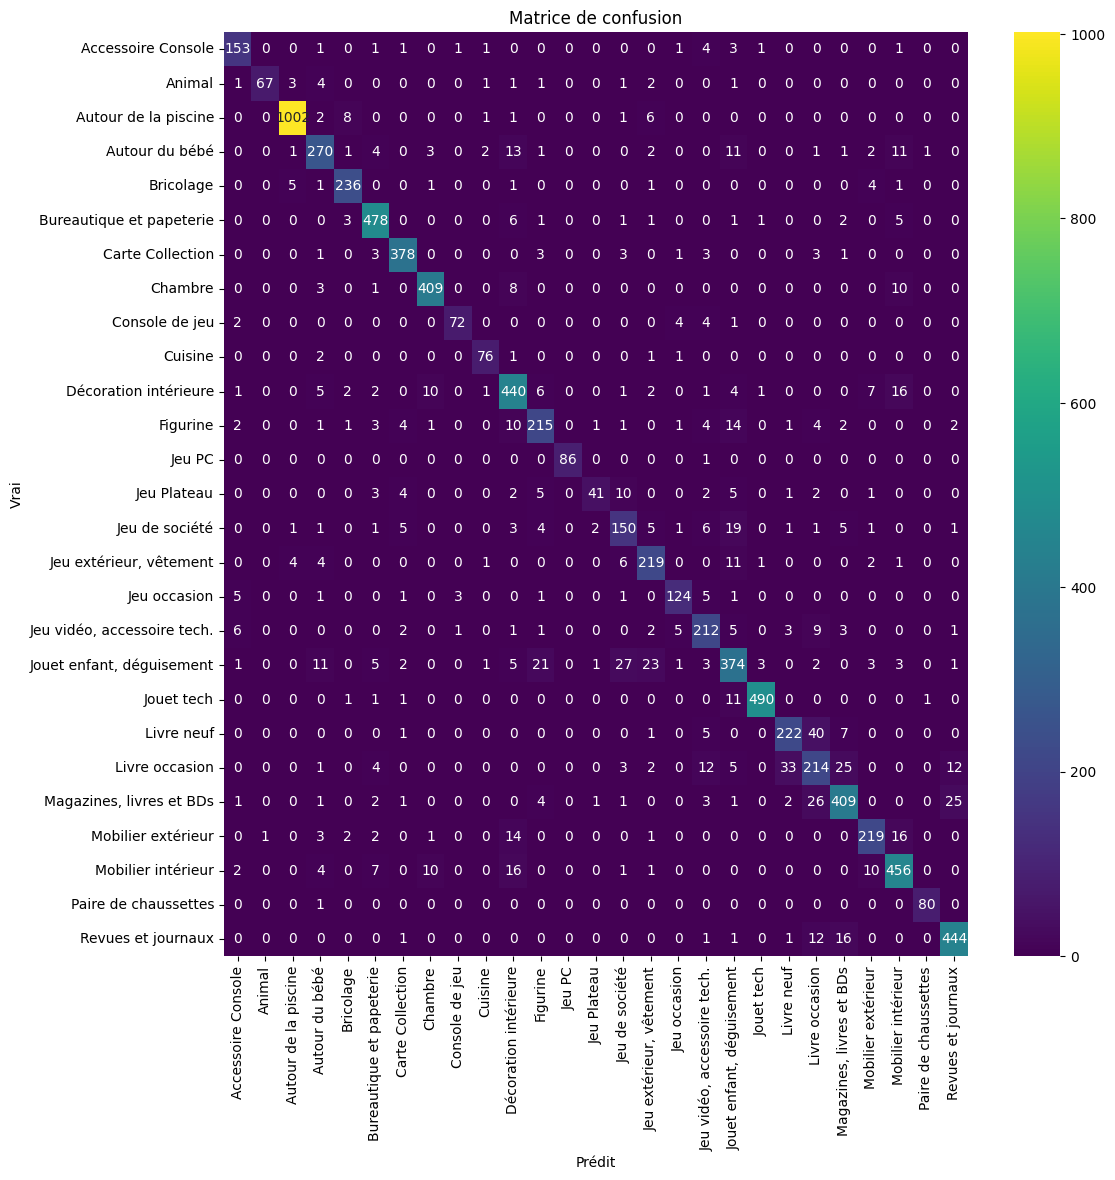

In [23]:

# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="viridis")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [24]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.88      0.91      0.89       168
                     Animal       0.99      0.82      0.89        82
       Autour de la piscine       0.99      0.98      0.98      1021
             Autour du bébé       0.85      0.83      0.84       324
                  Bricolage       0.93      0.94      0.94       250
   Bureautique et papeterie       0.92      0.96      0.94       499
           Carte Collection       0.94      0.95      0.95       396
                    Chambre       0.94      0.95      0.94       431
             Console de jeu       0.94      0.87      0.90        83
                    Cuisine       0.90      0.94      0.92        81
      Décoration intérieure       0.84      0.88      0.86       499
                   Figurine       0.82      0.81      0.81       267
                     Jeu PC       1.00      0.99      0.99        87
                Jeu Plateau      

# Fonctions

Préparer un DataFrame pour trainer.predict()

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

def prepare_dataset(df, tokenizer):
    # Tokenisation des textes de la colonne 'text_fr'
    encodings = tokenizer(df['text_fr'].tolist(), truncation=True, padding=True, max_length=512)
    # Création du dataset
    dataset = Dataset(encodings)
    return dataset


Obtenir les prédictions sous forme de probabilités

In [26]:
def get_predictions(trainer, dataset):
    # Obtenir les prédictions (logits)
    predictions_output = trainer.predict(dataset)
    predictions = predictions_output.predictions
    # Convertir les logits en probabilités
    probabilities = torch.softmax(torch.tensor(predictions), dim=1).numpy()
    return predictions, probabilities

# Validation

## Préparation du Dataset validation

In [27]:
df_val = pd.read_csv('output/data-preprocessing-resampling/df_val.csv', index_col=0)

In [28]:
df_val['prdtypecode'] = label_encoder.fit_transform(df_val['prdtypecode'])

# Séparation des données et des étiquettes
val_texts, val_labels = df_val['text_fr'].tolist(), df_val['prdtypecode'].tolist()

Tokenise et encode

In [29]:
val_dataset = prepare_dataset(df_val, tokenizer)

## Effectuer les prédictions

In [30]:
predictions_val, probabilities_val = get_predictions(trainer, val_dataset)

## Evaluer Validation

In [31]:
# Calcul des prédictions finales à partir des logits
y_pred_val = np.argmax(predictions_val, axis=1)

In [32]:
# Calcul des métriques de performance
accuracy = accuracy_score(val_labels, y_pred_val)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, y_pred_val, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.8858926048045219
Precision: 0.8869095669874142
Recall: 0.8858926048045219
F1-Score: 0.8859209629315719


Score du modèle : 0.8858926048045219


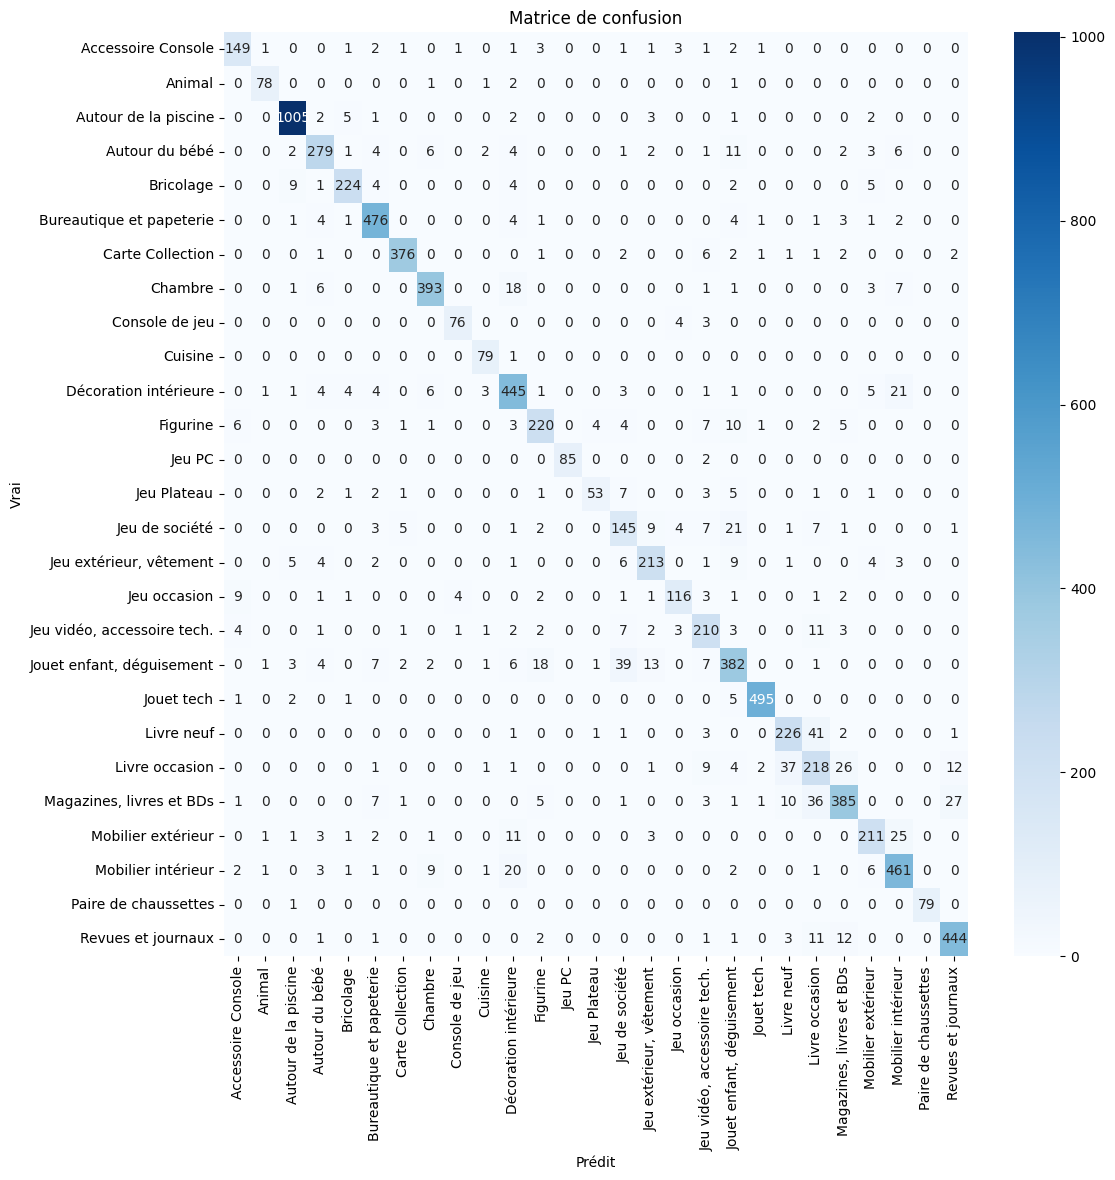

In [33]:
# Conversion des étiquettes de validation et des prédictions en leurs formes originales
val_labels_original = label_encoder.inverse_transform(val_labels)
y_val_original = label_encoder.inverse_transform(y_pred_val)
# Conversion des codes en labels lisibles pour la visualisation
y_val_visu = [prdcodetype2label.get(code, "Label inconnu") for code in val_labels_original]
y_pred_val_visu = [prdcodetype2label.get(code, "Label inconnu") for code in y_val_original]

# Calculer le score du modèle sur les labels lisibles
score = accuracy_score(y_val_visu, y_pred_val_visu)
print("Score du modèle :", score)

# Création et affichage de la matrice de confusion
mat_conf = pd.crosstab(pd.Series(y_val_visu, name="Vrai"), pd.Series(y_pred_val_visu, name="Prédit"), dropna=False)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [34]:
print(classification_report(y_val_visu, y_pred_val_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.87      0.89      0.88       168
                     Animal       0.94      0.94      0.94        83
       Autour de la piscine       0.97      0.98      0.98      1021
             Autour du bébé       0.88      0.86      0.87       324
                  Bricolage       0.93      0.90      0.91       249
   Bureautique et papeterie       0.92      0.95      0.93       499
           Carte Collection       0.97      0.95      0.96       395
                    Chambre       0.94      0.91      0.93       430
             Console de jeu       0.93      0.92      0.92        83
                    Cuisine       0.89      0.99      0.93        80
      Décoration intérieure       0.84      0.89      0.87       500
                   Figurine       0.85      0.82      0.84       267
                     Jeu PC       1.00      0.98      0.99        87
                Jeu Plateau      

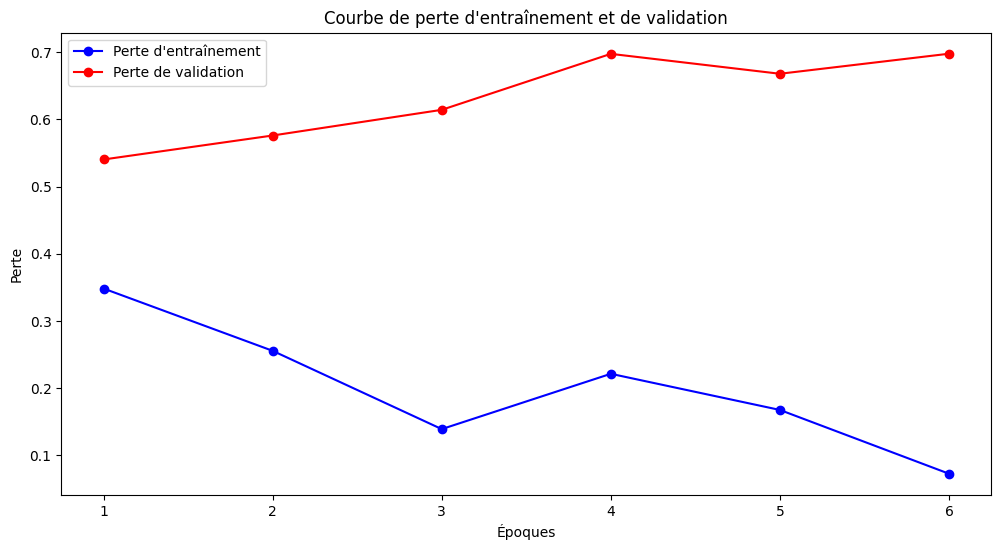

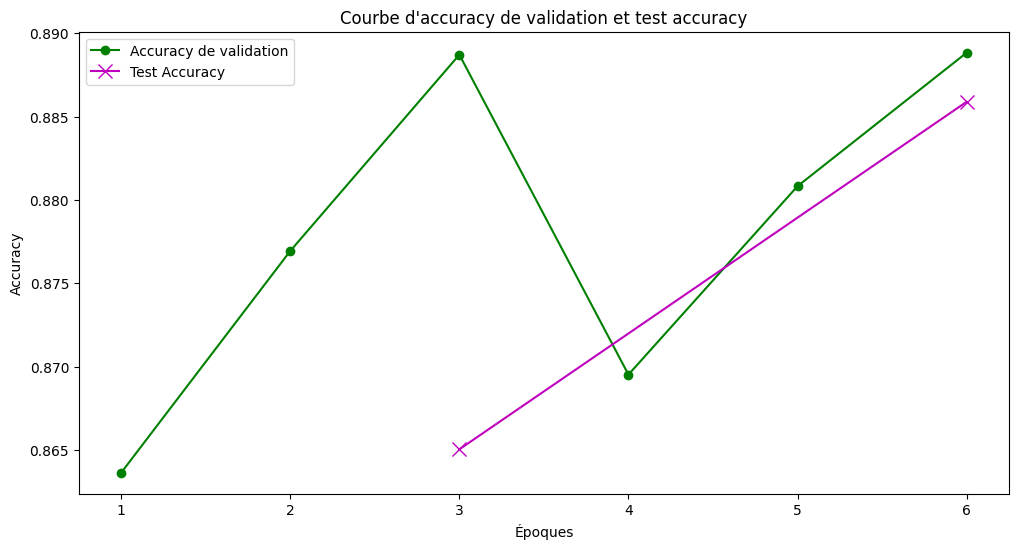

In [35]:
# Simuler des données de log pour les entrainements succeccifs
epochs = range(1, 7)
training_loss = [0.3484, 0.2557, 0.1392, 0.2215, 0.1677, 0.0728]
validation_loss = [0.540434, 0.576121, 0.614319, 0.697622, 0.667997, 0.697822]
accuracy = [0.863636, 0.876943, 0.888719, 0.869524, 0.880829, 0.888837]
# "test accuracy" n'est pas fourni pour toutes les époques, donc il ne sera pas inclus dans le graphique général.
# Nous allons le tracer séparément pour les époques où il est disponible.
test_accuracy_epochs = [3, 6]
test_accuracy = [0.86504, 0.885892]

# Tracer la perte d'entraînement et de validation
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, 'b-o', label='Perte d\'entraînement')
plt.plot(epochs, validation_loss, 'r-o', label='Perte de validation')
plt.title('Courbe de perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Tracer l'accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, 'g-o', label='Accuracy de validation')
# Ploter séparément l'accuracy de test pour les époques disponibles
plt.plot(test_accuracy_epochs, test_accuracy, 'm-x', label='Test Accuracy', markersize=10)
plt.title('Courbe d\'accuracy de validation et test accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Fonctions pour effectuer les prédiction sur un texte

Fonction pour Tokeniser le Texte

In [36]:
def prepare_text_for_prediction(text, tokenizer):
    # Tokeniser le texte
    encodings = tokenizer(text, truncation=True, padding=True, return_tensors="pt", max_length=512)
    return encodings

In [37]:
def display_category_probabilities(probabilities, label_encoder):
    # Obtenir les labels de catégorie pour chaque indice
    categories = label_encoder.classes_

    # S'assurer que probabilities est un Numpy array; sinon, convertissez-le
    if not isinstance(probabilities, np.ndarray):
        probabilities = np.array(probabilities)

    for i, prob in enumerate(probabilities[0]):  # Assumer que probabilities est pour un seul échantillon
        print(f"{categories[i]}: {prob:.4f}")

Combinons les fonctions précédentes en une seule fonction globale qui prend en entrée un texte, le tokenizer, et le modèle, et retourne les probabilités de prédiction.

In [38]:
def get_prediction_for_text(text, tokenizer, model, label_encoder):
    # Préparer le texte pour la prédiction
    encodings = prepare_text_for_prediction(text, tokenizer)
    # Obtenir l'appareil sur lequel le modèle est chargé
    device = next(model.parameters()).device
    # Déplacer les encodings sur le même appareil que le modèle
    encodings = {k: v.to(device) for k, v in encodings.items()}

    # Convertir les logits en probabilités avec softmax
    with torch.no_grad():  # Ne pas calculer de gradient pour cette opération
        predictions = model(**encodings)
        probabilities = torch.softmax(predictions.logits, dim=1)
        predicted_category = torch.argmax(probabilities, dim=1)

    # Convertir la catégorie prédite en format approprié pour LabelEncoder
    predicted_category_cpu = predicted_category.cpu().numpy()  # S'assurer que le tensor est sur CPU
    predicted_category_original = label_encoder.inverse_transform(predicted_category_cpu)

    return predicted_category_original, probabilities.cpu().numpy()  # S'assurer que les probabilités sont aussi sur CPU


In [39]:
text = "Joyeuse Saint-Valentin Jetez Taie D'oreiller Sweet Love Coussin Carré Couverture"
predicted_category, probabilities = get_prediction_for_text(text, tokenizer, model, label_encoder)

# Afficher la catégorie prédite et les probabilités
print(f"Catégorie prédite : {predicted_category.item()}")
print(f"Probabilités : {probabilities}")

Catégorie prédite : 1920
Probabilités : [[1.0269113e-06 2.3010870e-07 2.5415753e-07 1.5288813e-06 2.4351780e-06
  1.9731291e-07 1.9928334e-06 6.7333226e-06 1.4804414e-06 3.8658308e-07
  1.4206328e-06 4.8009383e-07 1.5296142e-05 8.6923828e-04 9.9897504e-01
  1.3401811e-07 1.0019910e-04 5.4208789e-07 2.1467308e-06 1.6928046e-06
  1.6712474e-06 1.8360226e-06 7.7747909e-06 6.3158501e-07 1.0291849e-06
  4.1627886e-06 4.0624866e-07]]


In [40]:
display_category_probabilities(probabilities, label_encoder)

10: 0.0000
40: 0.0000
50: 0.0000
60: 0.0000
1140: 0.0000
1160: 0.0000
1180: 0.0000
1280: 0.0000
1281: 0.0000
1300: 0.0000
1301: 0.0000
1302: 0.0000
1320: 0.0000
1560: 0.0009
1920: 0.9990
1940: 0.0000
2060: 0.0001
2220: 0.0000
2280: 0.0000
2403: 0.0000
2462: 0.0000
2522: 0.0000
2582: 0.0000
2583: 0.0000
2585: 0.0000
2705: 0.0000
2905: 0.0000


In [41]:
def display_predictions_with_labels(predicted_category_original, probabilities, prdcodetype2label):
    # Convertir l'indice de catégorie prédite en label lisible
    predicted_label = prdcodetype2label.get(predicted_category_original[0], "Label inconnu")

    print(f"Catégorie prédite: {predicted_label}")

    # Afficher chaque probabilité avec son label correspondant
    print("Probabilités par catégorie :")
    for idx, prob in enumerate(probabilities[0]):  # Probabilities  pour un seul échantillon
        # Utiliser idx pour trouver le label original correspondant dans le dictionnaire
        category_label = prdcodetype2label.get(idx, "Label inconnu")
        print(f"{category_label}: {prob:.4f}")

In [42]:
display_predictions_with_labels(predicted_category, probabilities, prdcodetype2label)

Catégorie prédite: Chambre
Probabilités par catégorie :
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Livre occasion: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0009
Label inconnu: 0.9990
Label inconnu: 0.0000
Label inconnu: 0.0001
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
Label inconnu: 0.0000
